In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import RandomizedSearchCV

In [21]:
train_data = pd.read_csv("/kaggle/input/foogg-data/train_set.csv")
test_data = pd.read_csv("/kaggle/input/foogg-data/test_set.csv")
val_data = pd.read_csv("/kaggle/input/foogg-data/val_set.csv")

In [22]:
columns_to_drop = ['30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km', '2hr_vsby_km', 
                   '2.5hr_vsby_km', '6hr_vsby_km', '30min_fog', '1hr_fog', '1.5hr_fog', 
                   '2hr_fog', '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', 
                   '1hr_fog_type', '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type',
                   '3hr_fog_type', '6hr_fog_type', '3hr_onset_cond', 'date_time_IST']

In [23]:
train_data = train_data.drop(columns=columns_to_drop)
val_data = val_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [24]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [25]:
X_train = train_scaled[:, :-1]  
y_train = train_scaled[:, -1]   

X_val = val_scaled[:, :-1]
y_val = val_scaled[:, -1]

X_test = test_scaled[:, :-1]
y_test = test_scaled[:, -1]

In [26]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [27]:
gbr = GradientBoostingRegressor(random_state=42)

In [28]:
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [29]:
random_search.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  27.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  28.6s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  42.4s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  14.2s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  27.3s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  42.2s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.8s
[CV] END learning_rate=0.1, max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [30]:
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4, 'learning_rate': 0.1}


In [31]:
best_gbr = random_search.best_estimator_

In [32]:
test_predictions = best_gbr.predict(X_test)

In [33]:
y_train_mean = train_data.iloc[:, -1].mean()
y_train_std = train_data.iloc[:, -1].std()

In [34]:
y_test_inv = y_test * y_train_std + y_train_mean
test_predictions_inv = test_predictions * y_train_std + y_train_mean

In [35]:
mse = mean_squared_error(y_test_inv, test_predictions_inv)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MSE: 0.01432705295185757
RMSE: 0.11969566805802777


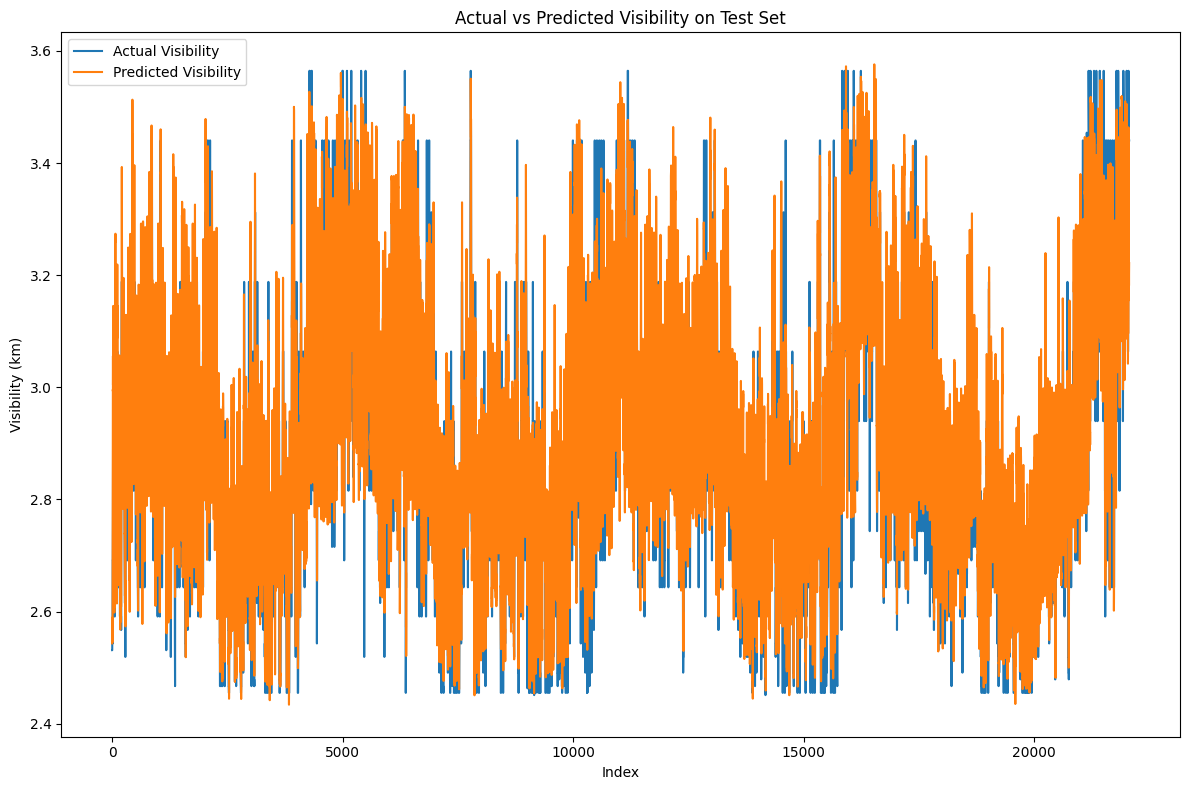

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual Visibility')
plt.plot(test_predictions_inv, label='Predicted Visibility')
plt.title('Actual vs Predicted Visibility on Test Set')
plt.xlabel('Index')
plt.ylabel('Visibility (km)')
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
current_visibility = y_test_inv[-1]
predicted_next_3hr_visibility = test_predictions_inv[-1]
actual_next_3hr_visibility = y_test_inv[-1]  # Adjust based on your data

print(f'Current Visibility: {current_visibility} km')
print(f'Predicted Visibility for next 3 hours: {predicted_next_3hr_visibility} km')
print(f'Actual Visibility for next 3 hours: {actual_next_3hr_visibility} km')

Current Visibility: 3.4403003754722574 km
Predicted Visibility for next 3 hours: 3.2215344617959882 km
Actual Visibility for next 3 hours: 3.4403003754722574 km
